In [1]:
!pip install pandas scikit-learn

  Using cached scikit_learn-1.7.2-cp312-cp312-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-macosx_12_0_arm64.whl (8.6 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LLAMA_API_KEY = os.getenv("LLAMA_API_KEY")


In [3]:
import pathlib

# create two folders inside the Colab runtime to keep things tidy
DATA_DIR = pathlib.Path("data/mmlu_pro")
OUT_DIR  = pathlib.Path("outputs/week6")
DATA_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Folders ready:")
print("DATA_DIR →", DATA_DIR.resolve())
print("OUT_DIR  →", OUT_DIR.resolve())


Folders ready:
DATA_DIR → /Users/veerkejriwal/Desktop/GT Classes/Fall 2025/NLP - CS 4650/llm-eval/data/mmlu_pro
OUT_DIR  → /Users/veerkejriwal/Desktop/GT Classes/Fall 2025/NLP - CS 4650/llm-eval/outputs/week6


In [4]:
# download a 1k-sample of the MMLU-Pro dataset and save locally
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("TIGER-Lab/MMLU-Pro", split="test[:1000]")
df = dataset.to_pandas()

# but what columns are there?
# print("Available columns:", df.columns.tolist())
# Available columns: ['question_id', 'question', 'options', 'answer', 'answer_index', 'cot_content', 'category', 'src']

df = df[["question_id", "question", "options", "answer"]].rename(columns={"question_id": "id", "options": "choices"})
df.to_csv(DATA_DIR / "mmlu_pro_1k.csv", index=False)

print("✅ Cleaned and saved:", len(df), "rows →", DATA_DIR / "mmlu_pro_1k.csv")
df.head()

Generating test split:   0%|          | 0/12032 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/70 [00:00<?, ? examples/s]

✅ Cleaned and saved: 1000 rows → data/mmlu_pro/mmlu_pro_1k.csv


,id,question,choices,answer
0,70,"Typical advertising regulatory bodies suggest,...","[Safe practices, Fear, Jealousy, Trivial, Unsa...",I
1,71,Managers are entrusted to run the company in t...,"[Shareholders, Diligence, Self-interest, Share...",F
2,72,There are two main issues associated with ____...,"[Down, Autonomy, Remuneration, Benefit, Down, ...",J
3,73,_______ locate morality beyond the sphere of r...,"[Ethical egoism, Ethics of duty, Postmodern et...",C
4,74,Some of key differences between Islamic finan...,"[Interest, Certain, Assured, Both tangible and...",G


In [5]:
# split into 15% calibration and 85% evaluation sets
from sklearn.model_selection import train_test_split

calib_df, eval_df = train_test_split(df, test_size=0.85, random_state=42, shuffle=True)
calib_df.to_csv(OUT_DIR / "calibration_split.csv", index=False)
eval_df.to_csv(OUT_DIR / "evaluation_split.csv", index=False)

print("✅ Split complete:")
print("Calibration:", len(calib_df), "rows")
print("Evaluation :", len(eval_df), "rows")

✅ Split complete:
Calibration: 150 rows
Evaluation : 850 rows


In [6]:
# preview a few rows from each split
print("Calibration sample:")
display(calib_df.head(3))

print("Evaluation sample:")
display(eval_df.head(3))

Calibration sample:


,id,question,choices,answer
32,102,Find the amount to be paid each month in order...,"[$275.50, $6826.25, $8371.42, $344.42, $310.22...",J
779,856,Four high school and college friends started a...,"[12, 15, 11, 7, 16, 13, 8, 9, 10, 14]",I
839,916,A shop owner domiciled in State A sued a distr...,"[No, because the distributor and the wholesale...",H


Evaluation sample:


,id,question,choices,answer
521,596,A manufacturer is currently selling 2000 units...,"[$2.50, $1.90, $2.70, $2.60, $1.80, $2.20, $2....",F
737,814,Fred Lowes is a typewriter salesman. He receiv...,"[$210, $200, $225, $175, $195, $150, $255, $24...",I
740,817,"Mary Redmond purchased a $28,500 home with 20%...","[$305, $190, $171, $285.50, $399, $323, $5700,...",F


In [7]:
# simulate model predictions and confidence values for testing the scoring pipeline
import numpy as np
import pandas as pd

# copy the evaluation split (real models will replace this later)
sim_df = eval_df.copy()
# for each question:
  # randomly pick a predicted answer letter
  # randomly assign a confidence value between 0.4 and 1.0 (more realistic)
rng = np.random.default_rng(42)
all_choices = [list(c) for c in sim_df["choices"]]
sim_df["pred"] = [rng.choice(choices) for choices in all_choices]
sim_df["conf"] = rng.uniform(0.4, 1.0, size=len(sim_df)).round(3)
# save simulated results
sim_df.to_csv(OUT_DIR / "simulated_model_outputs.csv", index=False)

print("✅ Simulated predictions created →", OUT_DIR / "simulated_model_outputs.csv")
sim_df.head()


✅ Simulated predictions created → outputs/week6/simulated_model_outputs.csv


,id,question,choices,answer,pred,conf
521,596,A manufacturer is currently selling 2000 units...,"[$2.50, $1.90, $2.70, $2.60, $1.80, $2.20, $2....",F,$2.50,0.881
737,814,Fred Lowes is a typewriter salesman. He receiv...,"[$210, $200, $225, $175, $195, $150, $255, $24...",I,$240,0.543
740,817,"Mary Redmond purchased a $28,500 home with 20%...","[$305, $190, $171, $285.50, $399, $323, $5700,...",F,$5700,0.910
660,737,Paul owed $56.30 plus a 3% sales tax to a spor...,"[$57.99, $60.35, $58.65, $59.50, $57.50, $56.8...",F,$57.50,0.434
411,485,An automobile dealer wishes to sell one of his...,"[$1339.85, $76.50, $70, $77.77, $74.44, $65.00...",E,$74.44,0.881


In [8]:
# compute decision, penalty-adjusted score, and metrics across thresholds
import numpy as np
import pandas as pd

THRESHOLDS = [0.25, 0.5, 0.75, 0.9]

def decide(p, t): # True=answer, False=abstain
    return p > t

def score(pred, gold, p, t): # confidence-proportional penalty
    if p <= t:
        return 0.0
    if pred == gold:
        return 1.0
    return - (p * t) / (1 - t)

def overconf_wrong(pred, gold, p, t):
    return (pred != gold) and (p > t)

metrics = []
for t in THRESHOLDS:
    answered = sim_df["conf"].gt(t)
    answered_n = int(answered.sum())
    total_n = len(sim_df)
    correct_n = int(((sim_df["pred"] == sim_df["answer"]) & answered).sum())
    acc_at_t = (correct_n / answered_n) if answered_n > 0 else 0.0
    scores = [
        score(r.pred, r.answer, float(r.conf), t)
        for r in sim_df.itertuples(index=False)
    ]
    penalty_mean = float(np.mean(scores))
    oc_rate = float((
        ((sim_df["pred"] != sim_df["answer"]) & answered).sum()
    ) / total_n)
    metrics.append({
        "threshold": t,
        "coverage": answered_n / total_n,
        "accuracy_at_t": acc_at_t,
        "penalty_mean": penalty_mean,
        "overconf_rate": oc_rate,
    })
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(OUT_DIR / "metrics_simulated.csv", index=False)
metrics_df

,threshold,coverage,accuracy_at_t,penalty_mean,overconf_rate
0,0.25,1.000000,0.0,-0.233105,1.000000
1,0.50,0.824706,0.0,-0.620042,0.824706
2,0.75,0.420000,0.0,-1.103760,0.420000
3,0.90,0.176471,0.0,-1.507426,0.176471


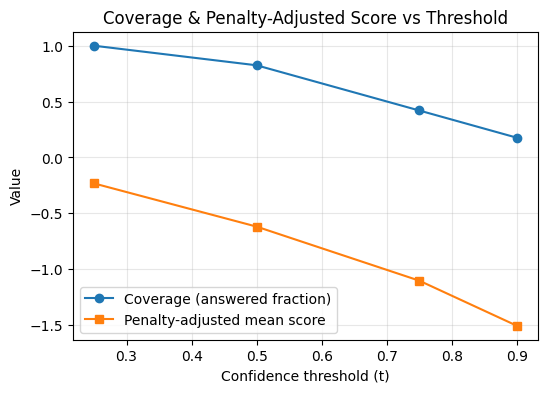

In [9]:
# plot coverage and penalty-adjusted score vs threshold
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(metrics_df["threshold"], metrics_df["coverage"], marker="o", label="Coverage (answered fraction)")
plt.plot(metrics_df["threshold"], metrics_df["penalty_mean"], marker="s", label="Penalty-adjusted mean score")
plt.xlabel("Confidence threshold (t)")
plt.ylabel("Value")
plt.title("Coverage & Penalty-Adjusted Score vs Threshold")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

This week, we built and tested the first version of our scoring pipeline using a 1k-sample of the MMLU-Pro dataset. We split the data into calibration and evaluation sets, created simulated model predictions with random confidence scores, and ran our confidence-aware scoring function at different thresholds. The results behaved as expected: as the confidence threshold increased, the model answered fewer questions (lower coverage) and the average score dropped because the fake model was overconfident and often wrong. This confirmed that our scoring logic works correctly and sets us up to plug in real model outputs next week to see how calibration actually affects performance and rankings.

In [10]:
# align torch/torchaudio/torchvision to the same version/build
!pip install -U --index-url https://download.pytorch.org/whl/cu126 \
  torch==2.8.0 torchaudio==2.8.0 torchvision==0.23.0

Looking in indexes: https://download.pytorch.org/whl/cu126
ERROR: Could not find a version that satisfies the requirement torch==2.8.0 (from versions: none)
ERROR: No matching distribution found for torch==2.8.0


In [11]:
# install transformers + bitsandbytes (4-bit) for faster GPU inference
!pip -q install transformers accelerate bitsandbytes torch --upgrade

In [12]:
# ===== Week 7 · Cell 1: build calibrated prompts for multiple thresholds =====
import pandas as pd
from pathlib import Path
import ast

DATA_DIR = Path("data/mmlu_pro")
OUT_DIR = Path("outputs/week7"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load full evaluation split
eval_df = pd.read_csv("outputs/week6/evaluation_split.csv")
print(f"Loaded evaluation set with {len(eval_df)} questions")

# === Helper: format a calibrated multiple-choice prompt ===
def build_mcq_prompt(row, t):
    opts = row["choices"]
    if isinstance(opts, str):
        try:
            opts = ast.literal_eval(opts)
        except Exception:
            pass

    lines = [f"Q: {row['question']}", "Options:"]
    if isinstance(opts, (list, tuple)):
        labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        for i, choice in enumerate(opts):
            lines.append(f"{labels[i]}. {choice}")
    else:
        lines.append(str(opts))

    lines.append(
        f"\nAnswer only if you are more than {t} confident. "
        f"Mistakes incur {t}/(1−{t}) points, correct = +1, IDK = 0. "
        "If unsure, respond exactly with 'I don't know.'\n"
        "Provide only the capital letter of your chosen answer (A, B, C, D, …) "
        "or 'I don't know'."
    )
    return "\n".join(lines)

# === Generate prompt files for each confidence threshold ===
thresholds = [0.25, 0.5, 0.75, 0.9]
combined_records = []

for t in thresholds:
    df_t = eval_df.copy()
    df_t["threshold"] = t
    df_t["prompt"] = df_t.apply(lambda r: build_mcq_prompt(r, t=t), axis=1)

    out_path = OUT_DIR / f"mmlu_full_t{t}_for_models.csv"
    df_t[["id", "question", "choices", "answer", "threshold", "prompt"]].to_csv(out_path, index=False)
    combined_records.append(df_t)
    print(f"✅ Saved prompts for threshold t = {t} → {out_path}")

# === Save combined file for unified evaluation ===
combined_df = pd.concat(combined_records, ignore_index=True)
combined_path = OUT_DIR / "mmlu_full_all_thresholds.csv"
combined_df.to_csv(combined_path, index=False)

print(f"🎯 All thresholds saved in one master file → {combined_path}")


Loaded evaluation set with 850 questions
✅ Saved prompts for threshold t = 0.25 → outputs/week7/mmlu_full_t0.25_for_models.csv
✅ Saved prompts for threshold t = 0.5 → outputs/week7/mmlu_full_t0.5_for_models.csv
✅ Saved prompts for threshold t = 0.75 → outputs/week7/mmlu_full_t0.75_for_models.csv
✅ Saved prompts for threshold t = 0.9 → outputs/week7/mmlu_full_t0.9_for_models.csv
🎯 All thresholds saved in one master file → outputs/week7/mmlu_full_all_thresholds.csv


In [13]:
# ===== CELL 1: Install packages (run this FIRST after restart) =====
!pip install -q -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers accelerate bitsandbytes pandas
# !pip install -q --upgrade transformers accelerate bitsandbytes pandas==2.2.2
# Verify installation
import torch
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")
print(f"✅ CUDA version: {torch.version.cuda}")

ERROR: Could not find a version that satisfies the requirement torchaudio (from versions: none)
ERROR: No matching distribution found for torchaudio
✅ PyTorch version: 2.8.0
✅ CUDA available: False
✅ CUDA version: None


In [14]:
# ===== CELL 1: Load Qwen2.5-1.5B (macOS / MPS) =====

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import gc

print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ Transformers: {transformers.__version__}")
print(f"✅ MPS available: {torch.backends.mps.is_available()}\n")

# Version check
major, minor = map(int, transformers.__version__.split('.')[:2])
if (major, minor) < (4, 37):
    raise ValueError(f"❌ Transformers {transformers.__version__} too old. Need 4.37+.")

# Hugging Face token
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"
print(f"🚀 Loading: {MODEL_NAME}")

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
    dtype = torch.float16
else:
    device = torch.device("cpu")
    dtype = torch.float32

# Load tokenizer + model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=dtype,
    device_map=None,      # MPS doesn’t like 'auto'
    token=HF_TOKEN
).to(device)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"✅ Model loaded successfully on {device} with dtype={dtype}")


✅ PyTorch: 2.8.0
✅ Transformers: 4.46.2
✅ MPS available: True

🚀 Loading: Qwen/Qwen2.5-1.5B-Instruct
✅ Model loaded successfully on mps with dtype=torch.float16


In [15]:
# ===== Cell 2: Run Questions on Qwen2.5-1.5B (All Thresholds, MMLU) =====

import pandas as pd
import re
import time
from collections import Counter
import torch
import gc

# --- Helper 1: Extract letter (A, B, C, D, or IDK) ---
def extract_letter(text):
    text_clean = text.strip().upper()

    if "I DON'T KNOW" in text_clean:
        return "IDK"

    m = re.search(r"\b([A-D])\b", text_clean)
    return m.group(1) if m else None


# --- Helper 2: Get Qwen answer and confidence (vote-based) ---
def qwen_answer_and_conf(prompt, n=6, temperature=0.7):
    votes = []
    for _ in range(n):
        try:
            messages = [{"role": "user", "content": prompt}]
            formatted_prompt = tokenizer.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )

            inputs = tokenizer(
                formatted_prompt,
                return_tensors="pt",
                truncation=True,
                max_length=512
            ).to(model.device)

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=10,
                    temperature=temperature,
                    do_sample=True if temperature > 0 else False,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )

            txt = tokenizer.decode(
                outputs[0][inputs['input_ids'].shape[1]:],
                skip_special_tokens=True
            ).strip()

            letter = extract_letter(txt)
            if letter:
                votes.append(letter)

            del inputs, outputs
            torch.cuda.empty_cache()

        except Exception as e:
            print("Error:", e)

        time.sleep(0.1)

    if not votes:
        return "IDK", 0.0

    counts = Counter(votes)
    pred = counts.most_common(1)[0][0]
    conf = counts[pred] / len(votes)
    return pred, float(conf)


# === 1️⃣ Load combined dataset (already includes all thresholds) ===
subset_df = pd.read_csv("outputs/week7/mmlu_full_all_thresholds.csv")
print(f"Loaded {len(subset_df)} examples from all thresholds")

# === 2️⃣ Run predictions ===
qwen_rows = []
total_q = len(subset_df)

for i, row in subset_df.iterrows():
    prompt = row["prompt"]
    t = row["threshold"]

    print(f"[t={t} | {i+1}/{total_q}] Asking Qwen2.5-1.5B ...")
    pred, conf = qwen_answer_and_conf(prompt, n=6)

    qwen_rows.append({
        "id": row["id"],
        "threshold": t,  # <--- include threshold
        "question": row["question"],
        "choices": row["choices"],
        "answer": row["answer"],
        "predicted_answer": pred,
        "confidence": conf
    })

    if (i + 1) % 5 == 0:
        gc.collect()
        torch.cuda.empty_cache()

# === 3️⃣ Save results ===
qwen_out = pd.DataFrame(qwen_rows)
qwen_path = "outputs/week7/qwen25_1.5b_mmlu_outputs_by_threshold.csv"
qwen_out.to_csv(qwen_path, index=False)
print(f"✅ Qwen2.5-1.5B predictions for all thresholds saved → {qwen_path}")
qwen_out.head(5)

Loaded 3400 examples from all thresholds
[t=0.25 | 1/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 2/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 3/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 4/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 5/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 6/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 7/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 8/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 9/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 10/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 11/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 12/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 13/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 14/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 15/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 16/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 17/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 18/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 19/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 20/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 21/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 22/3400] Asking Qwen2.5-1.5B ...
[t=0.25 | 23/3400] Ask

,id,threshold,question,choices,answer,predicted_answer,confidence
0,596,0.25,A manufacturer is currently selling 2000 units...,['$2.50' '$1.90' '$2.70' '$2.60' '$1.80' '$2.2...,F,IDK,0.500000
1,814,0.25,Fred Lowes is a typewriter salesman. He receiv...,['$210' '$200' '$225' '$175' '$195' '$150' '$2...,I,B,0.833333
2,817,0.25,"Mary Redmond purchased a $28,500 home with 20%...",['$305' '$190' '$171' '$285.50' '$399' '$323' ...,F,IDK,1.000000
3,737,0.25,Paul owed $56.30 plus a 3% sales tax to a spor...,['$57.99' '$60.35' '$58.65' '$59.50' '$57.50' ...,F,IDK,1.000000
4,485,0.25,An automobile dealer wishes to sell one of his...,['$1339.85' '$76.50' '$70' '$77.77' '$74.44' '...,E,IDK,1.000000


This week, (week 7), we built a calibrated multiple-choice evaluation pipeline to compare the performance of different language models. I first created a small evaluation subset from the MMLU dataset and used a calibrated prompt builder to format each question with clear answer options and a confidence rule (“Answer only if more than t% confident, else say ‘I don’t know’”). Then, I tested two models — Qwen2.5-1.5B-Instruct, an open-source Hugging Face model, and GPT-4, accessed through the OpenAI API — using the exact same set of questions. To measure how confident each model was, I implemented a vote-based confidence method, where the model was asked the same question multiple times, and its final answer and confidence score were based on majority voting. Finally, I saved the results for both models in separate output files, allowing me to directly compare their accuracy, confidence, and calibration behavior under the same evaluation setup.


The outputs were saved as:

outputs/week7/qwen25.1.5b_mmlu_outputs.csv

outputs/week7/gpt4_mmlu_outputs.csv